In [ ]:
# Importa le librerie necessarie
from google.colab import drive
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import pywt
from tqdm import tqdm
import os
from scipy.stats import kurtosis


In [ ]:
# Monta il drive di Google
drive.mount('/content/drive')

# Percorso del file CSV
file_path = '/content/drive/MyDrive/dataset/dataset.csv'

# Apri il file CSV in modalità lettura
#with open(csv_path, mode='r') as csv_file:
    # Leggi il contenuto del file CSV
 #   csv_reader = csv.reader(csv_file)
    # Itera sulle righe del file CSV

Mounted at /content/drive


In [ ]:
def load_and_clean_data(file_path):
    # Carica il dataset dal file
    df = pd.read_csv(file_path)

    print(f"Before cleaning: {df.shape}")

    # Rimuovi eventuali righe contenenti valori mancanti
    df.dropna(inplace=True)

    # Rimuovi eventuali duplicati
    df.drop_duplicates(inplace=True)

    print(f"After cleaning: {df.shape}")

    return df

In [ ]:
cleaned_df = load_and_clean_data(file_path)

Before cleaning: (125, 80002)
After cleaning: (125, 80002)


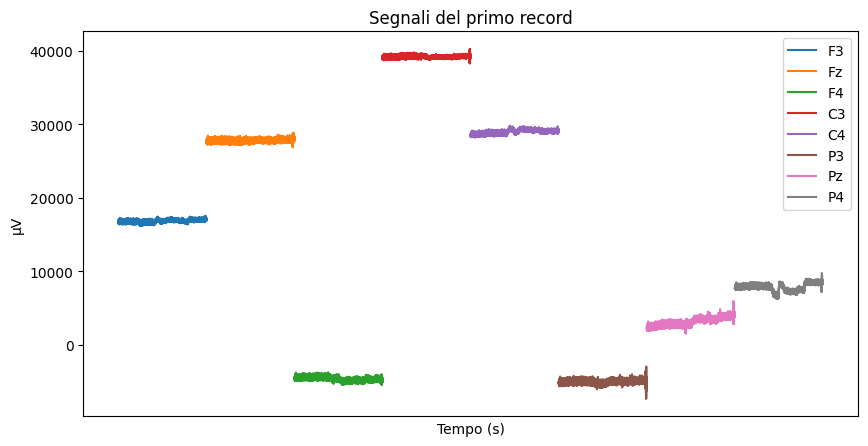

In [ ]:
# seleziona il primo record e rimuovi la prima e l'ultima colonna
record = cleaned_df.iloc[0, 1:-1]

# crea una lista di etichette per i canali
canali = ['canale ' + str(i+1) for i in range(8)]
ss = ["F3", "Fz", "F4", "C3", "C4", "P3", "Pz", "P4"]

# plotta i segnali del primo record per ogni canale
plt.figure(figsize=(10, 5))
plt.title('Segnali del primo record')
plt.xlabel('Tempo (s)')
plt.ylabel('µV')
for i in range(8):
    plt.plot(record[i*10000:(i+1)*10000], label=ss[i])
    ax = plt.gca()  # ottieni l'oggetto Axes associato alla figura corrente
    ax.yaxis.set_units('µV')
    #plt.xticks(range(0, 10001, 500), range(0, 21, 1))
    plt.xticks([], [])
plt.legend()
plt.show()

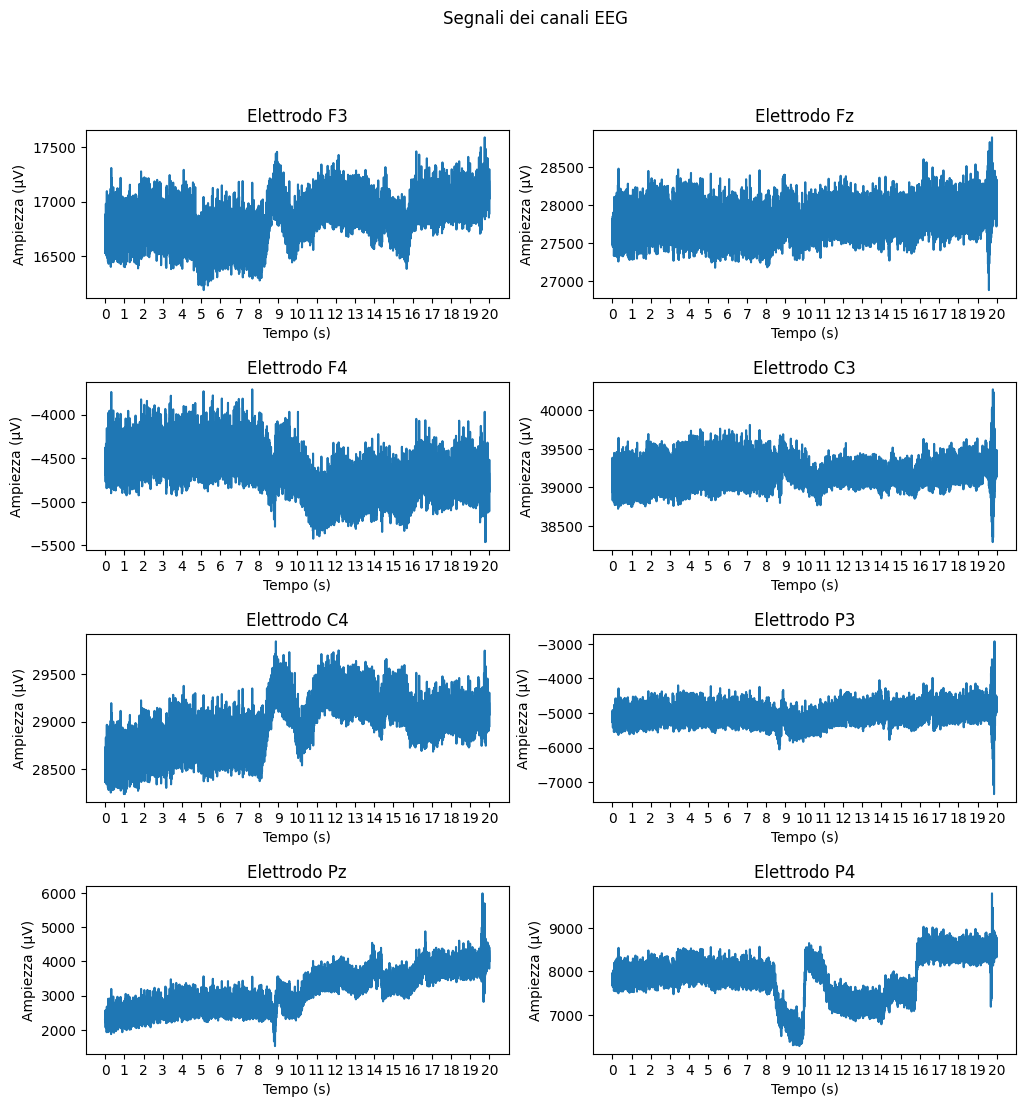

In [ ]:
# dividi il record in segmenti di 5000 campioni
channels = [record[i:i+10000] for i in range(0, len(record), 10000)]

# definisci la griglia di subplot
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(12, 12))
ss = ["F3", "Fz", "F4", "C3", "C4", "P3", "Pz", "P4"]
# plotta ogni canale in un subplot
for i, channel in enumerate(channels):
    ax = axs[i//2, i%2]
    ax.plot(channel)
    ax.set_title(f"Elettrodo {ss[i]}")
    ax.set_xlabel('Tempo (s)')
    ax.set_ylabel('Ampiezza (µV)')
    ax.yaxis.set_units('µV')
    ax.set_xticks(range(0, 10001, 500))
    ax.set_xticklabels(range(0, 21, 1))
    fig.subplots_adjust(hspace=0.5)



# aggiungi un titolo al plot
fig.suptitle("Segnali dei canali EEG")

# mostra il plot
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from scipy import signal
# carica il dataset
def plot_fft_signal(row = 0, electrode = 1, plot = None ):
  # prende i primi 10000 capioni del primo record
  signal_of_first_channel = cleaned_df.iloc[row, 1:-1][(electrode-1)*10000:electrode*10000]
  fs = 500  # Frequenza di campionamento
  t = np.arange(0, 20, 1/fs)

  fft_signal = np.fft.fft(signal_of_first_channel)

  n = len(fft_signal)
  freqs = np.arange(n) * (500 / n)  #Fs = 500 freq di campioname

  if plot != None:
    fig, axs = plt.subplots(nrows=6, ncols=2, figsize=(12, 12))
    ax = axs[0, 0]
    ax.plot(t, signal_of_first_channel)
    ax.set_xlim(0, 20)
    ax.set_xlabel('Tempo (s)')
    ax.set_ylabel('Ampiezza')
    ax.set_title('Segnale nel dominio del tempo original signal')
    fig.subplots_adjust(hspace=0.5)

    # Plot del segnale nel dominio delle frequenze
    ax = axs[0 , 1]
    ax.plot(freqs[:n // 2], np.abs(fft_signal[:n // 2]))
    ax.set_xlabel('Frequenza (Hz)')
    ax.set_ylabel('Ampiezza')
    ax.set_title('Spettro di frequenza original signal')
    fig.subplots_adjust(hspace=0.5)

  freq_bands = {
      'delta': (0.5, 4),
      'theta': (4, 8),
      'alpha': (8, 13),
      'beta': (13, 30),
      'gamma': (30, 50)
  }

  filtered_signals_dict = {}
  for i, (item, values) in enumerate(freq_bands.items()):
    fc_max = values[1]
    fc_min = values[0]


    b, a = signal.butter(4, fc_max / (fs / 2), 'lowpass')  # Coefficienti del filtro

    # Applica il filtro al segnale
    filtered_signal = signal.filtfilt(b, a, signal_of_first_channel)

    # Applica un filtro passa-alto per rimuovere le frequenze inferiori a fc_min Hz
    b, a = signal.butter(4, fc_min / (fs / 2), 'highpass')  # Coefficienti del filtro
    filtered_signal = signal.filtfilt(b, a, filtered_signal)

    # applica la Trasformata di Fourier
    fft_signal = np.fft.fft(filtered_signal)

    n = len(fft_signal)

    freqs = np.arange(n) * (500 / n)  #Fs = 500 freq di campioname

    filtered_signals_dict[item] = filtered_signal

    if plot != None:
      # Plot del segnale nel dominio del tempo
      ax = axs[i+1, 0]
      ax.plot(t, filtered_signal)
      ax.set_xlim(0, 20)
      ax.set_xlabel('Tempo (s)')
      ax.set_ylabel('Ampiezza')
      ax.set_title(f'Segnale nel dominio del tempo {item}')
      fig.subplots_adjust(hspace=1)

      # Plot del segnale nel dominio delle frequenze
      ax = axs[i+1 , 1]
      ax.plot(freqs[:n // 2], np.abs(fft_signal[:n // 2]))
      ax.set_xlabel('Frequenza (Hz)')
      ax.set_ylabel('Ampiezza')
      ax.set_title(f'Spettro di frequenza {item}')
      ax.set_xlim(fc_min, fc_max)

  if plot != None:
    # aggiungi un titolo al plot
    fig.suptitle("Varie onde celebrali")

    plt.show()
  return filtered_signals_dict

# Plot del segnale originale e del segnale filtrato
#plt.plot(signal_of_first_channel, label='Segnale originale')
#plt.plot(filtered_signal, label='Segnale filtrato')
#plt.legend()
#plt.show()






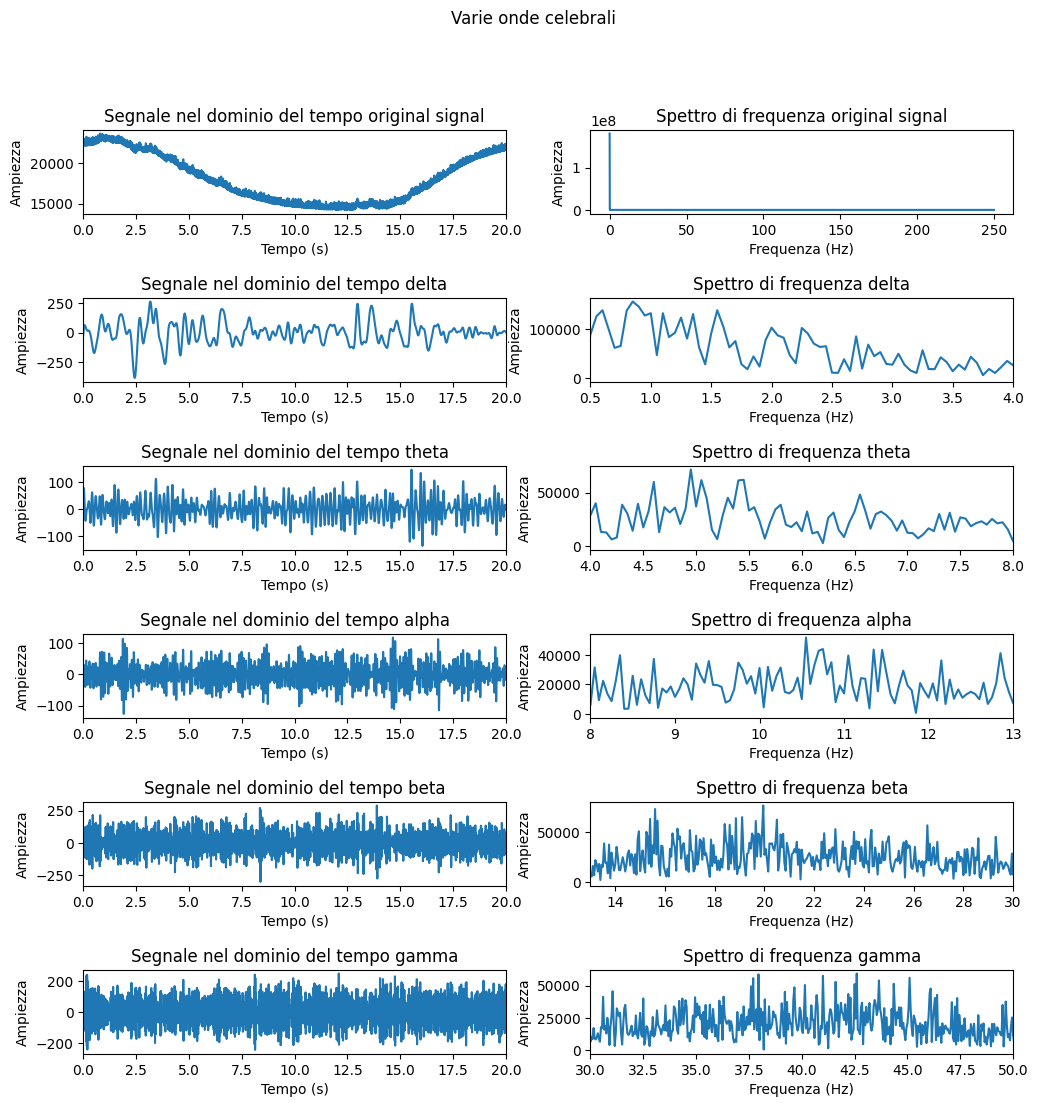

In [ ]:
filtered_signals_dict = plot_fft_signal(124,8,1) #row, electrod, plot or not

La potenza di un segnale è tipicamente calcolata come la somma dei quadrati dei valori assoluti del segnale

L'energia di un segnale, d'altra parte, è calcolata come la somma dei valori assoluti del segnale

L'entropia è una misura della "disordine" o dell'"incertezza" di un sistema. Nei calcoli sopra, viene utilizzata per valutare la distribuzione delle probabilità di potenza e energia del segnale filtrato.

In [ ]:
import scipy.stats as stats

import numpy as np

def feature(filtered_signals_dict, brain_wave):
    onda = list(filtered_signals_dict.keys())[brain_wave]
    filtered_signals_array = np.array(list(filtered_signals_dict[onda]))

    # Calcolo della potenza
    power = np.sum(np.abs(filtered_signals_array)**2)

    # Calcolo dell'energia
    energy = np.sum(np.abs(filtered_signals_array))

    # Calcolo dell'entropia sulla potenza
    power_probabilities = np.abs(filtered_signals_array)**2 / power
    power_entropy = -np.sum(power_probabilities * np.log2(power_probabilities))

    # Calcolo dell'entropia sull'energia
    energy_probabilities = np.abs(filtered_signals_array) / energy
    energy_entropy = -np.sum(energy_probabilities * np.log2(energy_probabilities))

    # Calcola la media dell'onda cerebrale
    mean = np.mean(filtered_signals_array)

    # Calcola la deviazione standard dell'onda cerebrale
    std = np.std(filtered_signals_array)

    # Calcola il picco minimo dell'onda cerebrale
    peak_min = np.min(filtered_signals_array)

    # Calcola il picco massimo dell'onda cerebrale
    peak_max = np.max(filtered_signals_array)

    # Calcola la kurtosis dell'onda cerebrale
    kurt = kurtosis(filtered_signals_array)

    # Calcola l'entropia di Shannon dell'onda cerebrale
    shannon_entropy = -np.sum(power_probabilities * np.log2(power_probabilities))

    # Stampa i risultati dell'analisi
    #print(f"Potenza: {power} uV^2")
    #print("Media:", mean)
    #print("Deviazione Standard:", std)
    #print("Energia:", energy)
    return power, mean, std, energy, power_entropy, energy_entropy, peak_min, peak_max, kurt, shannon_entropy



In [ ]:
def take_target(row):
  return cleaned_df.iloc[row,-1]

def take_size(cleaned_df):
  return cleaned_df.shape[0]

In [ ]:
def header_generate():
  # Montare il drive
  drive.mount('/content/drive')

  # Definire il percorso del file CSV
  percorso_file_csv = f'/content/drive/MyDrive/dataset/features.csv'
  # Definire le etichette dei delta, theta, alpha, beta e gamma
  etichette_band = ['power', 'mean', 'std', 'energy','power_entropy','energy_entropy', 'peak_min', 'peak_max','kurtosis','shannon_entropy']

  # Creare un elenco di intestazioni per il CSV
  intestazione = []
  intestazione.append('target')
  for electrod in range(8):
    for colonna in ['delta', 'theta', 'alpha', 'beta', 'gamma']:
      for etichetta in etichette_band:
          intestazione.append(f"{colonna}_{etichetta}_{electrod}")


  # Aprire il file CSV in modalità scrittura
  with open(percorso_file_csv, mode='w', newline='') as file_csv:
      # Creare un writer CSV
      writer = csv.writer(file_csv)

      # Scrivere l'intestazione
      writer.writerow(intestazione)

  print(f"Intestazione del file CSV '{percorso_file_csv}' creata con successo.")

In [ ]:

def records_generate():
  record = []
  for row in tqdm(range(take_size(cleaned_df)), desc = "Progess"):
    record.append(take_target(row))
    for electrod in range(1,9):
      filtered_signals_dict = plot_fft_signal(row,electrod) #row, electrod, plot or not
      for onda in range(5):
        power, mean, std, energy, power_entropy, energy_entropy, peak_min, peak_max, kurtosis, shannon_entropy = feature(filtered_signals_dict,onda)
        record.append(power)
        record.append(mean)
        record.append(std)
        record.append(energy)
        record.append(power_entropy)
        record.append(energy_entropy)
        record.append(peak_min)
        record.append(peak_max)
        record.append(kurtosis)
        record.append(shannon_entropy)

    # Aprire il file CSV in modalità append
    with open('/content/drive/MyDrive/dataset/features.csv', mode='a', newline='') as file_csv:
        # Creare un writer CSV
        writer = csv.writer(file_csv)

        # Scrivere la lista "record" nel file CSV
        writer.writerow(record)
    record = []



In [ ]:
def generate_features():
  # Percorso del file da cancellare
  file_path = "/content/drive/MyDrive/dataset/features.csv"

  # Verifica se il file esiste
  if os.path.isfile(file_path):
      # Cancellazione del file
      os.remove(file_path)
      print("File cancellato con successo.")
  else:
      print("Il file non esiste.")

  header_generate()
  records_generate()

In [ ]:
generate_features()

File cancellato con successo.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Intestazione del file CSV '/content/drive/MyDrive/dataset/features.csv' creata con successo.


Progess: 100%|██████████| 125/125 [10:18<00:00,  4.95s/it]


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/dataset/features.csv')

In [ ]:
df.shape

(125, 401)

In [ ]:
df


,target,delta_power_0,delta_mean_0,delta_std_0,delta_energy_0,delta_power_entropy_0,delta_energy_entropy_0,delta_peak_min_0,delta_peak_max_0,delta_kurtosis_0,...,gamma_power_7,gamma_mean_7,gamma_std_7,gamma_energy_7,gamma_power_entropy_7,gamma_energy_entropy_7,gamma_peak_min_7,gamma_peak_max_7,gamma_kurtosis_7,gamma_shannon_entropy_7
0,portrait,2.206504e+07,1.398913,46.952600,3.348772e+05,11.730992,12.678964,-158.163221,136.937503,1.453856,...,2.995535e+07,0.020850,54.731474,437530.251360,12.240741,12.882912,-203.008671,229.459393,-0.004541,12.240741
1,portrait,5.682373e+06,-1.813078,23.768678,1.472971e+05,10.431527,12.611598,-204.026830,63.351958,21.938204,...,3.349100e+07,-0.007907,57.871406,464397.806343,12.263128,12.888335,-203.693279,216.062927,-0.106558,12.263128
2,portrait,4.403022e+07,1.557233,66.336994,4.660034e+05,11.632683,12.655240,-239.670719,265.266880,2.215935,...,3.422996e+07,0.042180,58.506358,467492.186862,12.246518,12.880153,-201.936593,196.851031,-0.084408,12.246518
3,portrait,1.489324e+07,-1.907492,38.544597,2.459167e+05,11.278645,12.449892,-198.834557,150.879021,4.006561,...,2.601902e+07,-0.012566,51.008842,408703.024257,12.260798,12.884097,-172.652846,182.769527,-0.119499,12.260798
4,portrait,1.121535e+07,0.871340,33.477982,2.095821e+05,10.825872,12.527050,-83.694890,247.786704,12.922304,...,3.365305e+07,0.021389,58.011247,464085.042339,12.261950,12.877902,-196.789508,195.648826,-0.152134,12.261950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,portrait,2.592274e+07,0.377050,50.912985,3.345307e+05,11.318251,12.553972,-224.546090,203.868216,3.667077,...,5.481413e+07,-0.007679,74.036568,598991.798663,12.311266,12.900333,-236.075358,226.306912,-0.298397,12.311266
121,portrait,2.290409e+09,1.695612,478.579144,3.744753e+06,12.154526,12.839260,-1485.482266,1612.176561,0.233459,...,5.773890e+07,0.041742,75.986106,611373.440633,12.283557,12.891163,-230.982509,251.354619,-0.216306,12.283557
122,emotion,6.291281e+08,-1.145460,250.821646,1.861490e+06,11.910779,12.747452,-863.825556,706.483506,0.943445,...,5.526339e+07,0.038908,74.339337,593965.402521,12.239403,12.881391,-287.800745,314.566039,0.012047,12.239403
123,beautiful,6.724155e+09,2.745946,820.004825,3.429068e+06,9.724053,11.597881,-5643.083708,4291.881373,17.036081,...,5.336254e+07,0.029715,73.049662,578875.132468,12.205097,12.865407,-272.231341,267.785869,0.062713,12.205097
